In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installations & Data Loading

In [2]:
sales_dir = '/content/drive/MyDrive/Data/sales.csv'
cat_dir = '/content/drive/MyDrive/Data/category.csv'
attributes_dir = '/content/drive/MyDrive/Data/attribute descriptions.xlsx'
stores_dir = '/content/drive/MyDrive/Data/store.csv'
subcat_dir = '/content/drive/MyDrive/Data/subcategory.csv'
prod_dir = '/content/drive/MyDrive/Data/products.json'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [4]:
!pip install Prophet
from prophet import Prophet

In [6]:
df = pd.read_csv(sales_dir)
df

,Date,Product_ID,Store_ID,Promotion_Flag,Discount_percent,Price,Sold_Units,Sales_Volume
0,2017-01-01,P1_,S7_,NaN,NaN,75.0,0.0,0.0
1,2017-01-02,P1_,S7_,NaN,NaN,75.0,0.0,0.0
2,2017-01-03,P1_,S7_,NaN,NaN,75.0,0.0,0.0
3,2017-01-04,P1_,S7_,NaN,NaN,75.0,0.0,0.0
4,2017-01-05,P1_,S7_,NaN,NaN,75.0,0.0,0.0
...,...,...,...,...,...,...,...,...
21736,2021-07-20,P12_,S7_,NaN,NaN,65.0,149.0,9685.0
21737,2021-07-21,P12_,S7_,NaN,NaN,65.0,149.0,9685.0
21738,2021-07-22,P12_,S7_,NaN,NaN,65.0,152.0,9880.0
21739,2021-07-23,P12_,S7_,NaN,NaN,65.0,156.0,10140.0


In [7]:
df.columns

Index(['Date', 'Product_ID', 'Store_ID', 'Promotion_Flag',
       ' Discount_percent ', 'Price', 'Sold_Units', 'Sales_Volume'],
      dtype='object')

In [86]:
df = df.rename(columns={' Discount_percent ':'Discount_percent'}) # Only column name with space

In [10]:
print(df['Store_ID'].unique())
print(df['Product_ID'].unique())
print(df['Promotion_Flag'].unique())

['S7_' nan]
['P1_' nan 'P2_' 'P3_' 'P4_' 'P5_' 'P6_' 'P7_' 'P8_' 'P9_' 'P10_' 'P11_'
 'P12_']
[nan  1.]


# Data Preparation (Cleaning & Exploration)

1. All Null values unders Discount Percent and Promotion flag are automatically consideredn as 0
2. All tabular data is brought into one table for better understanding and furher processing

In [11]:
df.isnull().sum()

Date                 1749
Product_ID           1749
Store_ID             1749
Promotion_Flag      20043
Discount_percent    20043
Price                1749
Sold_Units           1749
Sales_Volume         1749
dtype: int64

In [16]:
df[['Discount_percent','Promotion_Flag']]= df[['Discount_percent','Promotion_Flag']].fillna(0)

In [17]:
df_sales = df.sort_values(by=['Date']).reset_index().drop(columns=['index']).dropna()
df_sales

,Date,Product_ID,Store_ID,Promotion_Flag,Discount_percent,Price,Sold_Units,Sales_Volume
0,2017-01-01,P1_,S7_,0.0,0.0,75.0,0.0,0.0
1,2017-01-01,P9_,S7_,0.0,0.0,55.0,145.0,7975.0
2,2017-01-01,P4_,S7_,0.0,0.0,99.0,154.0,15246.0
3,2017-01-01,P6_,S7_,0.0,0.0,45.0,131.0,5895.0
4,2017-01-01,P7_,S7_,0.0,0.0,80.0,0.0,0.0
...,...,...,...,...,...,...,...,...
19987,2021-07-24,P3_,S7_,0.0,0.0,105.0,0.0,0.0
19988,2021-07-24,P2_,S7_,1.0,0.6,69.0,40.0,1104.0
19989,2021-07-24,P1_,S7_,1.0,0.6,75.0,42.0,1260.0
19990,2021-07-24,P11_,S7_,0.0,0.0,55.0,148.0,8140.0


In [19]:
df_cat = pd.read_csv('/content/drive/MyDrive/Data/category.csv', delimiter=';')
df_sub_cat = pd.read_csv('/content/drive/MyDrive/Data/subcategory.csv', delimiter=';')
df_prod= pd.read_json('/content/drive/MyDrive/Data/products.json')

In [20]:
df_cat

,Category_ID,Category_Label
0,1,Clothes
1,2,Toys
2,3,Electronics


In [21]:
df_sub_cat

,SubCategory_ID,SubCategory_Label
0,1,Summer
1,2,Winter
2,3,WholeYear
3,4,Children
4,5,Computer
5,6,Board games
6,7,Mobile phones


In [22]:
df_prod = df_prod.dropna()
df_prod

,Product_ID,Product_Description,Category,SubCategory,Line,Type
0,1,Shorts - cotton - white - L,1,1,Men,Pants & Skirts
1,2,Polo shirt - navy blue - XL,1,1,Men,Shirts
2,3,Thermal pants - Regular Fit - LYCRA,1,2,Men,Pants & Skirts
3,4,HUGO BOSS long-sleeved shirt XL,1,2,Men,Shirts
4,5,Bugatti Chino - Regular Fit - LYCRA,1,3,Men,Pants & Skirts
5,6,HUGO BOSS Business Shirt - white - 44/45,1,3,Men,Shirts
6,7,Cotton shorts - red - size M,1,1,Women,Pants & Skirts
7,8,Shirt - light blue - size S,1,1,Women,Shirts
8,9,Skirt - dark blue - size M,1,2,Women,Pants & Skirts
9,10,Lady's blouse casual - cotton - size 36,1,2,Women,Shirts


In [23]:
df_sub_cat = df_sub_cat.rename(columns={'SubCategory_ID':'SubCategory'})
df_prod2 = pd.merge(df_prod, df_sub_cat, on='SubCategory', how='left')
df_prod2 = df_prod2.rename(columns={'Product_ID':'Prod_ID'})
df_prod2

,Prod_ID,Product_Description,Category,SubCategory,Line,Type,SubCategory_Label
0,1,Shorts - cotton - white - L,1,1,Men,Pants & Skirts,Summer
1,2,Polo shirt - navy blue - XL,1,1,Men,Shirts,Summer
2,3,Thermal pants - Regular Fit - LYCRA,1,2,Men,Pants & Skirts,Winter
3,4,HUGO BOSS long-sleeved shirt XL,1,2,Men,Shirts,Winter
4,5,Bugatti Chino - Regular Fit - LYCRA,1,3,Men,Pants & Skirts,WholeYear
5,6,HUGO BOSS Business Shirt - white - 44/45,1,3,Men,Shirts,WholeYear
6,7,Cotton shorts - red - size M,1,1,Women,Pants & Skirts,Summer
7,8,Shirt - light blue - size S,1,1,Women,Shirts,Summer
8,9,Skirt - dark blue - size M,1,2,Women,Pants & Skirts,Winter
9,10,Lady's blouse casual - cotton - size 36,1,2,Women,Shirts,Winter


**- Using regular expressions extracting Product ID from the resp. column.**

**- Converting Date from object format into date format.**

In [24]:
df_sales = df_sales.convert_dtypes()
df_sales['Prod_ID'] = df_sales['Product_ID'].str.extract('(\d+)')
df_sales.drop(columns='Product_ID', inplace=True)

In [25]:
df_sales

,Date,Store_ID,Promotion_Flag,Discount_percent,Price,Sold_Units,Sales_Volume,Prod_ID
0,2017-01-01,S7_,0,0.0,75,0,0.0,1
1,2017-01-01,S7_,0,0.0,55,145,7975.0,9
2,2017-01-01,S7_,0,0.0,99,154,15246.0,4
3,2017-01-01,S7_,0,0.0,45,131,5895.0,6
4,2017-01-01,S7_,0,0.0,80,0,0.0,7
...,...,...,...,...,...,...,...,...
19987,2021-07-24,S7_,0,0.0,105,0,0.0,3
19988,2021-07-24,S7_,1,0.6,69,40,1104.0,2
19989,2021-07-24,S7_,1,0.6,75,42,1260.0,1
19990,2021-07-24,S7_,0,0.0,55,148,8140.0,11


In [26]:
df_sales['Prod_ID'] = df_sales['Prod_ID'].astype(int)
df_sales.dtypes

Date                string[python]
Store_ID            string[python]
Promotion_Flag               Int64
Discount_percent           Float64
Price                        Int64
Sold_Units                   Int64
Sales_Volume               Float64
Prod_ID                      int64
dtype: object

**The final table!**

In [28]:
df3 = pd.merge(df_sales, df_prod2, on='Prod_ID', how='left')
df3['Date'] = pd.to_datetime(df3['Date'], format='%Y-%m-%d')
df3

,Date,Store_ID,Promotion_Flag,Discount_percent,Price,Sold_Units,Sales_Volume,Prod_ID,Product_Description,Category,SubCategory,Line,Type,SubCategory_Label
0,2017-01-01,S7_,0,0.0,75,0,0.0,1,Shorts - cotton - white - L,1,1,Men,Pants & Skirts,Summer
1,2017-01-01,S7_,0,0.0,55,145,7975.0,9,Skirt - dark blue - size M,1,2,Women,Pants & Skirts,Winter
2,2017-01-01,S7_,0,0.0,99,154,15246.0,4,HUGO BOSS long-sleeved shirt XL,1,2,Men,Shirts,Winter
3,2017-01-01,S7_,0,0.0,45,131,5895.0,6,HUGO BOSS Business Shirt - white - 44/45,1,3,Men,Shirts,WholeYear
4,2017-01-01,S7_,0,0.0,80,0,0.0,7,Cotton shorts - red - size M,1,1,Women,Pants & Skirts,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,2021-07-24,S7_,0,0.0,105,0,0.0,3,Thermal pants - Regular Fit - LYCRA,1,2,Men,Pants & Skirts,Winter
19988,2021-07-24,S7_,1,0.6,69,40,1104.0,2,Polo shirt - navy blue - XL,1,1,Men,Shirts,Summer
19989,2021-07-24,S7_,1,0.6,75,42,1260.0,1,Shorts - cotton - white - L,1,1,Men,Pants & Skirts,Summer
19990,2021-07-24,S7_,0,0.0,55,148,8140.0,11,Lady's trousers - dark blue - size 36,1,3,Women,Pants & Skirts,WholeYear


In [29]:
df3['Day'] = df3['Date'].dt.day
df3['Month'] = df3['Date'].dt.month
df3['Year'] = df3['Date'].dt.year

**Sales Volume plot!**

<Axes: xlabel='Date'>

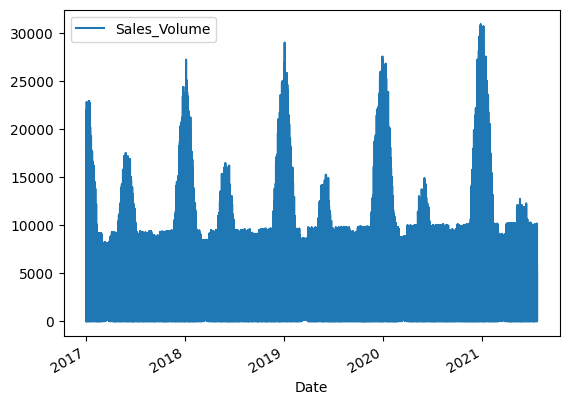

In [30]:
df3.plot(x='Date', y='Sales_Volume')

In [32]:
df_forecast = df3[['Date', 'Sales_Volume']]
df_forecast = df_forecast.rename(columns={'Date':'ds', 'Sales_Volume':'y'})
df_forecast

,ds,y
0,2017-01-01,0.0
1,2017-01-01,7975.0
2,2017-01-01,15246.0
3,2017-01-01,5895.0
4,2017-01-01,0.0
...,...,...
19987,2021-07-24,0.0
19988,2021-07-24,1104.0
19989,2021-07-24,1260.0
19990,2021-07-24,8140.0


# Forecast Modelling

In [36]:
model1 = Prophet()
model1.fit(df_forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnglef4e0/sc55n7ng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnglef4e0/tkgwiz9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89914', 'data', 'file=/tmp/tmpnglef4e0/sc55n7ng.json', 'init=/tmp/tmpnglef4e0/tkgwiz9r.json', 'output', 'file=/tmp/tmpnglef4e0/prophet_modelridw3n9g/prophet_model-20240603001204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:12:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:12:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
forecast_dates = model1.make_future_dataframe(freq='D', periods=200)
forecast_dates

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
1861,2022-02-05
1862,2022-02-06
1863,2022-02-07
1864,2022-02-08


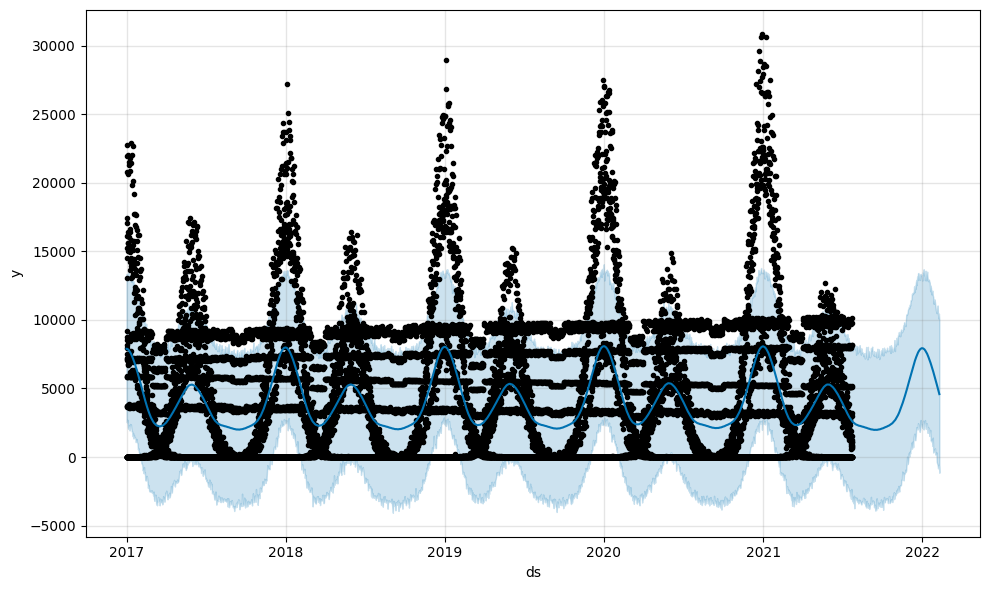

In [38]:
forecast = model1.predict(forecast_dates)
model1.plot(forecast)
plt.show()

In [39]:
df_forecast['ds1'] = df_forecast['ds'].dt.to_period('M')
df_forecast1 = df_forecast.groupby('ds1')['y'].sum().reset_index()
df_forecast1 = df_forecast1.rename(columns={'ds1':'ds'})
df_forecast1['ds'] = df_forecast1['ds'].dt.to_timestamp()
df_forecast1

,ds,y
0,2017-01-01,2396860.0
1,2017-02-01,1293094.4
2,2017-03-01,892920.0
3,2017-04-01,1215641.0
4,2017-05-01,1959846.0
5,2017-06-01,1909996.0
6,2017-07-01,1215292.2
7,2017-08-01,856093.0
8,2017-09-01,742198.5
9,2017-10-01,882014.0


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnglef4e0/lntcinoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnglef4e0/7cgji6do.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5', 'data', 'file=/tmp/tmpnglef4e0/lntcinoh.json', 'init=/tmp/tmpnglef4e0/7cgji6do.json', 'output', 'file=/tmp/tmpnglef4e0/prophet_modele3p5_jcr/prophet_model-20240603001434.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:14:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[]

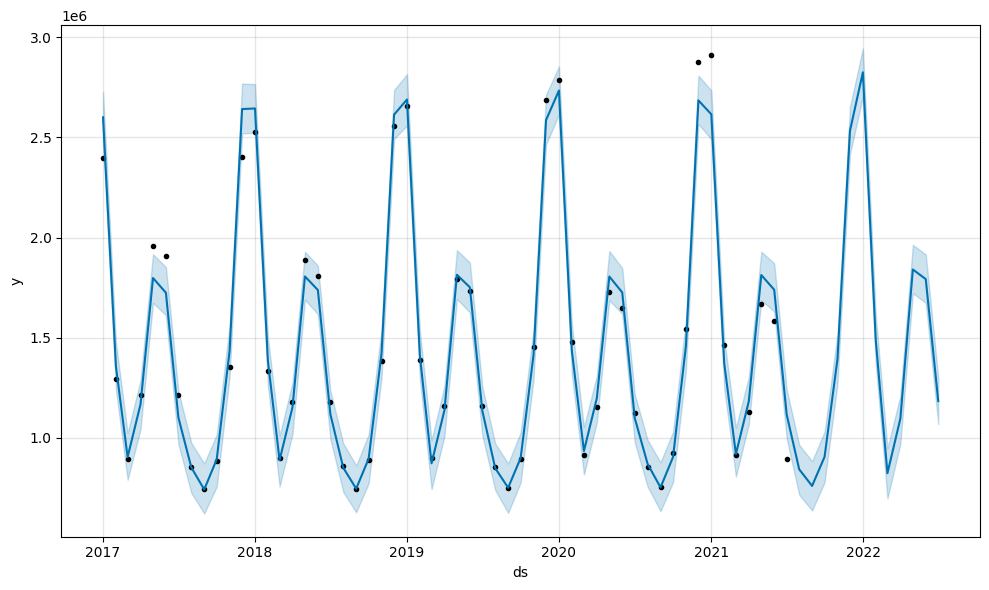

In [40]:
model2 = Prophet()
model2.fit(df_forecast1)
forecast_dates = model2.make_future_dataframe(periods=12, freq='M')
forecast = model2.predict(forecast_dates)
model2.plot(forecast)
plt.plot()

**Monthly forecast of the Sales Volume till next year**

In [94]:
forecast.iloc[55:,[0,15]]

,ds,yhat
55,2021-07-31,8.425265e+05
56,2021-08-31,7.593555e+05
57,2021-09-30,9.048980e+05
58,2021-10-31,1.393665e+06
59,2021-11-30,2.533402e+06
60,2021-12-31,2.825387e+06
61,2022-01-31,1.484741e+06
62,2022-02-28,8.228840e+05
63,2022-03-31,1.095355e+06
64,2022-04-30,1.840499e+06


# Data Inference
The categories
- Line (Men, Women)
- Sub category (1,2,3)

In [87]:
df3.groupby(['Year','Line'])[['Sales_Volume', 'Promotion_Flag']].sum().reset_index()

,Year,Line,Sales_Volume,Promotion_Flag
0,2017,Men,8347417.1,185
1,2017,Women,8773536.0,184
2,2018,Men,8238765.5,184
3,2018,Women,9003106.5,184
4,2019,Men,8164383.3,184
5,2019,Women,9264755.5,184
6,2020,Men,8230912.7,186
7,2020,Women,9544820.5,186
8,2021,Men,4856037.0,111
9,2021,Women,5708915.0,110


**Sales w.r.t Men vs Women**

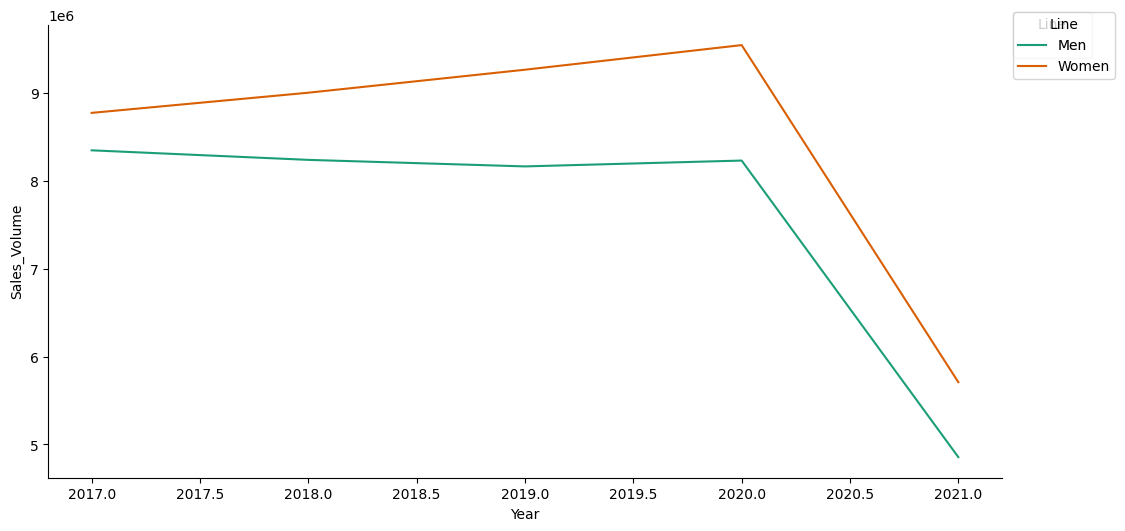

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Sales_Volume']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Line')):
  _plot_series(series, series_name, i)
  fig.legend(title='Line', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Sales_Volume')

In [44]:
df3.groupby(['Year'])['Promotion_Flag'].sum().reset_index()

,Year,Promotion_Flag
0,2017,369
1,2018,368
2,2019,368
3,2020,372
4,2021,221


**Sales Volume trend w.r.t each year**

In [74]:
df_2017 = df3.groupby(['Year', 'Month'])['Sales_Volume'].sum().reset_index().iloc[0:12,1:3]
df_2018 = df3.groupby(['Year', 'Month'])['Sales_Volume'].sum().reset_index().iloc[12:24,1:3]
df_2019 = df3.groupby(['Year', 'Month'])['Sales_Volume'].sum().reset_index().iloc[24:36,1:3]
df_2020 = df3.groupby(['Year', 'Month'])['Sales_Volume'].sum().reset_index().iloc[36:48,1:3]
df_2021 = df3.groupby(['Year', 'Month'])['Sales_Volume'].sum().reset_index().iloc[48:,1:3]


<Axes: xlabel='Month'>

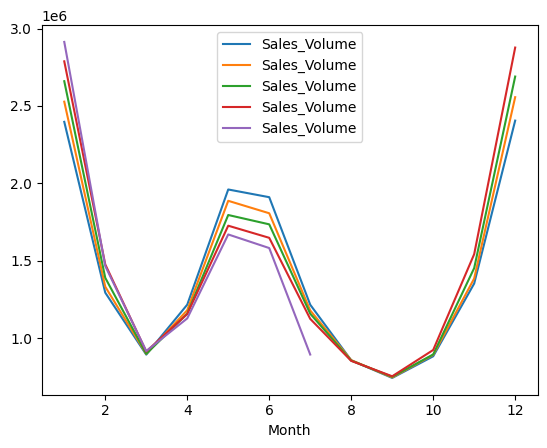

In [85]:
ax = df_2017.plot(x='Month', label='2017')
df_2018.plot(ax=ax, x='Month', label='2018')
df_2019.plot(ax=ax, x='Month', label='2019')
df_2020.plot(ax=ax, x='Month', label='2020')
df_2021.plot(ax=ax, x='Month', label='2021')

**Monthly trend in Sales per year**

<Axes: xlabel='Year'>

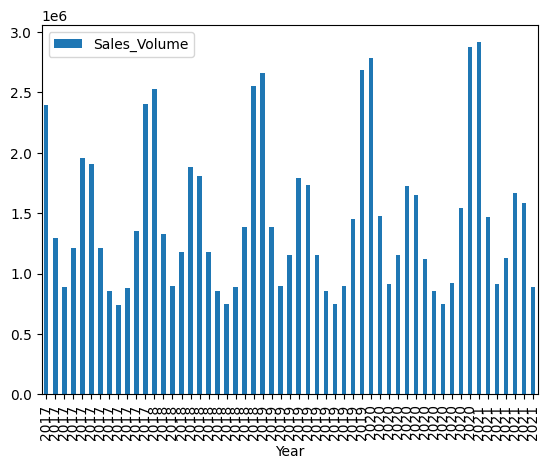

In [51]:
df3.groupby(['Year', 'Month'])['Sales_Volume'].sum().reset_index().plot(x='Year', y='Sales_Volume', kind='bar')

In [52]:
df3.groupby('SubCategory')['Sales_Volume'].sum().reset_index()

,SubCategory,Sales_Volume
0,1,14043707.5
1,2,23627436.1
2,3,42461505.5


# Questionnaire


**1. Exploration & Cleansing of the attached data (zip file) in Python**
**Question: What could a sales forecasting approach look like based on this data?**

Ans:

- With the given information the sales trend follows almost similar to that of previous years. It is expected to run down on a decreasing trend while expecting a huge rise by end of the year.

- It is also important to be noted that to achieve sales revenue of previous targets, Promotional offers should be introduced as the total offers till the given data point is less than the aggregates from previous years.



**2. Visualize the most important data / information in a tool of your choice (Python, Power BI, R,...)**

Ans:
- The most important feature is the Sales Volume. Using Prophet algorithm, the time series forecasting has been calculated.

- Additionally, the Sales revenue generated via Female consumers is higer compared to that of male, hence a keen Discount flags, Product availability w.r.t to the former category would be beneficial for better sales in the future.

- Lastly the Sub-category 3 Products bring in much significantly higher sales compared to that of the 1 and 2. Hence a stronger priority in handling these products would be beneficial.



**3. Assuming we had not just a small extract of the data, but sales data in terabyte size: What would your idea for a data model look like to set up a multidimensional reporting / dashboard on it?**

Ans:
With this current small data extract simple Python script on premise hardware was more than required for computations and data handling. For handling Terrabytes of data and if continous ingestion happens
then definitely larger models need to be tested such as LSTMs, GRUs or the Transformer pretrained models which can be finetuned on the exisiting TB of data. Once the finetuned model achieves a significant high accuracy on the test dataset, it can be deployed on Cloud/ERP applications for streaming data (e.g. for Batch streaming such Apache Airflow) which can host a Dashboard for reporting and the insights from the model based on the new data can regularly be checked up. It is important to brainstorm with the team and set KPI which influence the Business and these features can be integrated to the ML model & Dashboard reporting.